In [54]:
import sys
sys.path.append('..')
import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import configparser
from pathlib import Path
from scipy import interpolate
from scipy.stats import gaussian_kde

import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()

import MD_AE_tools.models.models as mdl_bias
import MD_AE_tools.models.models_no_bias as mdl_nobias
from project_specific_utils.helpers import GetAttr
import MD_AE_tools.mode_decomposition as md
import MD_AE_tools.ae_mode_selection as ranking
import MD_AE_tools.ae_mode_evaluation as mode_eval
from project_specific_utils.data_and_train import TrainNN_from_config, train_autoencder
from project_specific_utils import plot as myplot

config = configparser.ConfigParser()
config.read('../_system.ini')
results_dir = config['system_info']['alternate_location']

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]) 
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

In [55]:
parent_folder = Path(results_dir,'experiment_nonlinear')
!ls -v $parent_folder
folder_list = ! ls -v $parent_folder
# !tail -n 5 $parent_folder/*/log

0808_2mode1-2894758  0808_2mode5-2894762  0808_2mode9-2894766
0808_2mode2-2894759  0808_2mode6-2894763  0808_2mode10-2894767
0808_2mode3-2894760  0808_2mode7-2894764  grouping_modes_1.csv
0808_2mode4-2894761  0808_2mode8-2894765  grouping_modes_2.csv


In [56]:
# folder = '0808_2mode9-2255817'
# folder = '0808_2mode5-2894762'
folder = folder_list[7]
folder_path = Path(parent_folder,folder)
filename = Path(folder_path,'training_param.ini')
nonlinear = TrainNN_from_config(filename)

filename = Path(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    u_test = np.array(hf.get('u_test'))
    modes_train = np.array(hf.get('modes_train'))
    modes_test = np.array(hf.get('modes_test'))
    latent_train = np.array(hf.get('latent_train'))
    latent_test = np.array(hf.get('latent_test'))

    u_test_mean = np.array(hf.get('u_avg_test'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

MSE of traning is:  1.353413


Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.


/home/ym917/Documents/Codes/MD-CNN-AE/notebook_visualise/../MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


MSE reconstructed with 2 modes is:  1.4777343273162842
Calculating POD ...
User has selected classic POD
POD done.


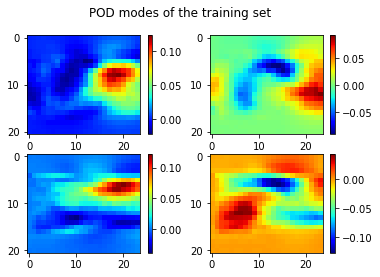

In [57]:
# data 
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure()
fig.suptitle('POD modes of the training set')
plt.subplot(221)
plt.imshow(phi1[:21,:],'jet')
plt.colorbar()
plt.subplot(223)
plt.imshow(phi1[21:,:],'jet')
plt.colorbar()
plt.subplot(222)
plt.imshow(phi2[:21,:],'jet')
plt.colorbar()
plt.subplot(224)
plt.imshow(phi2[21:,:],'jet')
plt.colorbar()

x_test = einsum('t y z u -> y z t u',np.squeeze(u_test))
X_test = np.vstack((x_test[:,:,:,0],x_test[:,:,:,1]))
pod_test = md.POD(X_test,method='classic')
A_test = pod_test.get_time_coefficient
Q_POD_test, lam_data_test = pod_test.get_modes

plt.show()

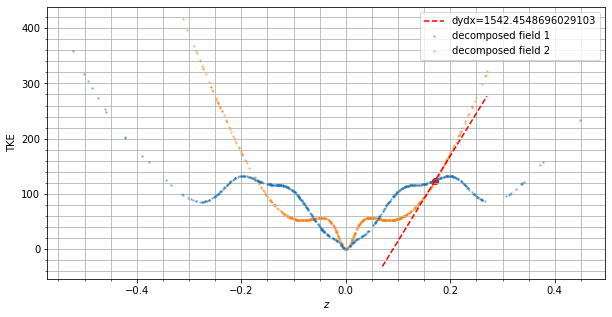

correlation coefficient 0.6862641128000114


In [58]:
ke = 0.5 * np.einsum('z t x y u -> z t', modes_test**2)

plt.figure(figsize=(10,5))
plt.scatter(latent_test[:,0], ke[0,:], alpha=0.4,label='decomposed field 1',s=2,zorder=2)
plt.scatter(latent_test[:,1], ke[1,:], alpha=0.4,label='decomposed field 2',s=2)
plt.xlabel('$z$')
plt.ylabel('TKE')
# plt.xlim([-0.01,0.15])
plt.minorticks_on()
plt.grid(which='both')
# plt.vlines(0.18,ymin=0.0001,ymax=500,linestyles='--',color='k')


### tangent
sort_idx = np.argsort(latent_test[:,1])
x_tan = latent_test[:,1][sort_idx]
y_tan = ke[1,:][sort_idx]
tck = interpolate.splrep(x_tan,y_tan)
x0 = 0.17
y0 = interpolate.splev(x0,tck)
dydx = interpolate.splev(x0,tck,der=1)
plt.scatter(x0,y0,c='r')
plot_tangent = np.linspace(x0-0.1,x0+0.1,50)
tngnt = lambda x: dydx*x + (y0-dydx*x0)
plt.plot(plot_tangent,tngnt(plot_tangent),'r--',label=f'dydx={dydx}')


plt.legend()
plt.show()

print('correlation coefficient', np.corrcoef(np.abs(latent_test[:,0]**2), ke[0,:])[0,1])

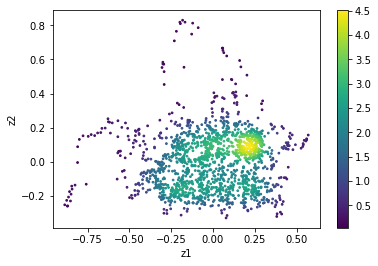

In [59]:
v1 = latent_train[:,0]
v2 = latent_train[:,1]
values = np.vstack([v1,v2])
kde = gaussian_kde(values)(values)
plt.figure()
plt.scatter(v1,v2,c=kde,s=3)
plt.xlabel('z1')
plt.ylabel('z2')
plt.colorbar()
plt.show()

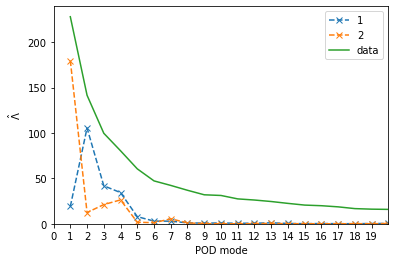

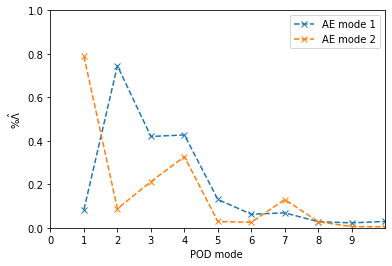

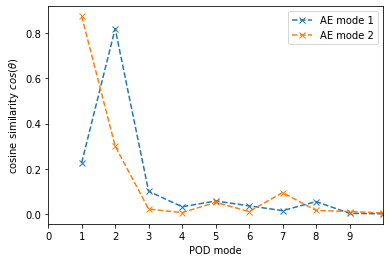

In [60]:
# reproject autoencoder modes onto data pod modes
lam_modes = mode_eval.equivalent_pca_energy(modes_train,Q_POD)
lam_modes_percent = lam_modes/lam_data
x_axis = np.arange(1,nonlinear.Nz*nonlinear.Ny*nonlinear.Nu+1)

plt.figure()
for i in range(nonlinear.latent_dim):
    plt.plot(x_axis,lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(x_axis,lam_data,label='data')
plt.xlim([0,20])
plt.xticks(range(20))
plt.ylim(bottom=0)
plt.ylabel('$\hat{\Lambda}$')
plt.xlabel('POD mode')
plt.legend()

plt.figure()
for i in range(nonlinear.latent_dim):
    plt.plot(x_axis,lam_modes_percent[i,:],label='AE mode '+str(i+1),linestyle='--',marker='x')
plt.xlim([0,10])
plt.ylim([0,1])
plt.xticks(range(10))
plt.legend()
plt.xlabel('POD mode ')
plt.ylabel('$\% \hat{\Lambda}$')
# plt.title('precentage of POD modes captured')


# Similarity between time coeffcient and latent variables
A = pod.get_time_coefficient #(nt, nx)
mag_A = einsum('t x -> x',A**2)**0.5

plt.figure()
# plt.suptitle('cosine similarity between the latent \nvariables and POD time coefficient')
plt.xlabel('POD mode')
plt.ylabel('cosine similarity $cos(\\theta)$')
for i in range(nonlinear.latent_dim):
    mag_z = np.sum(latent_train[:,i]**2)**0.5
    divisor = mag_A * mag_z
    z_dot_A = latent_train[:,[i]].T @ A
    cos_angle = (z_dot_A / divisor).flatten()
    plt.plot(x_axis, np.abs(cos_angle),label='AE mode '+str(i+1),linestyle='--',marker='x')
plt.xlim([0,10])
plt.xticks(range(10))
plt.legend()


plt.show()

In [61]:
print(modes_train.shape,Q_POD.shape) 

(2, 1632, 21, 24, 2) (1008, 1008)


## Decomposed fields

In [62]:
ntrain = modes_train.shape[1]
x_train = einsum('k t y z u -> k y z t u', modes_train)
B = []
for i in range(modes_train.shape[0]):
    X_train = np.vstack((x_train[i,:,:,:,0], x_train[i,:,:,:,1]))
    X_train = np.reshape(X_train,(-1, ntrain))
    b = einsum('x t, x m -> t m', X_train, Q_POD)
    B.append(b)
B = np.array(B) # [latent_dim, time, number of pod modes]

### decoder 1

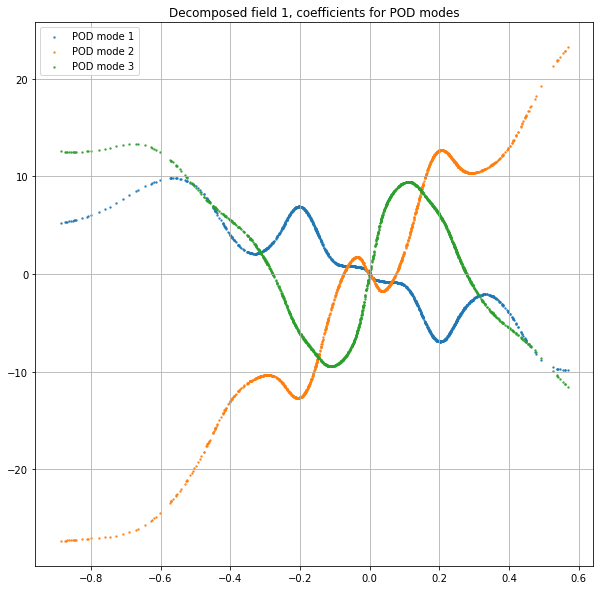

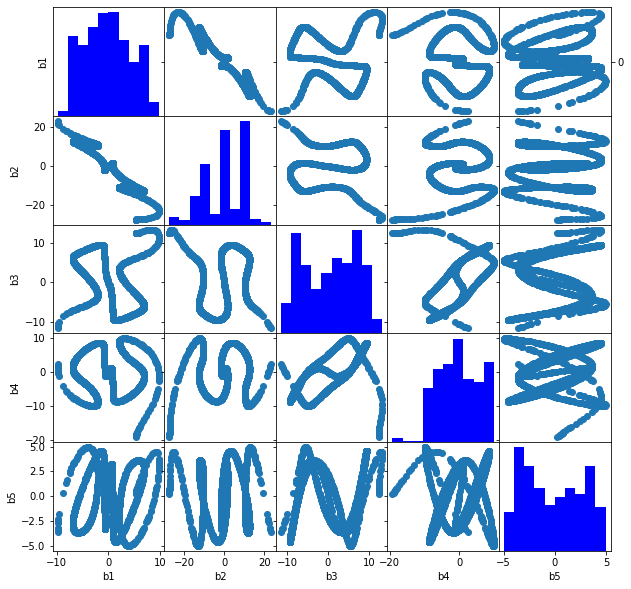

In [63]:
plt.figure(figsize=(10,10))
plt.title('Decomposed field 1, coefficients for POD modes')
for i in range(3):
    plt.scatter(latent_train[:,0], B[0,:,i], alpha=0.8,label=f'POD mode {i+1}',s=2)
plt.legend()
plt.grid()
plt.show()

fig, ax = myplot.scatter_matrix(B[0,:,:5],['b1','b2','b3','b4','b5'],kwargs_figure={'figsize':(10,10)},kwargs_hist={'color':'b'})

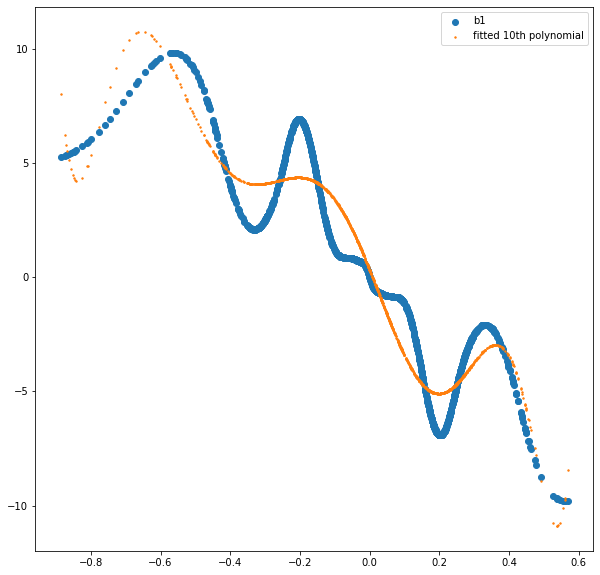

In [79]:
i = 0
degree = 10
fn = np.polynomial.polynomial.Polynomial.fit(latent_train[:,0],B[0,:,i],degree)
fn_coeff = fn.convert().coef
fitted = np.polynomial.polynomial.polyval(latent_train[:,0],fn_coeff)
fig = plt.figure(figsize=(10,10))
plt.scatter(latent_train[:,0],B[0,:,i],label=f'b{i+1}')
plt.scatter(latent_train[:,0],fitted,label=f'fitted {degree}th polynomial',s=2)
plt.legend()
plt.show()

### decoder 2

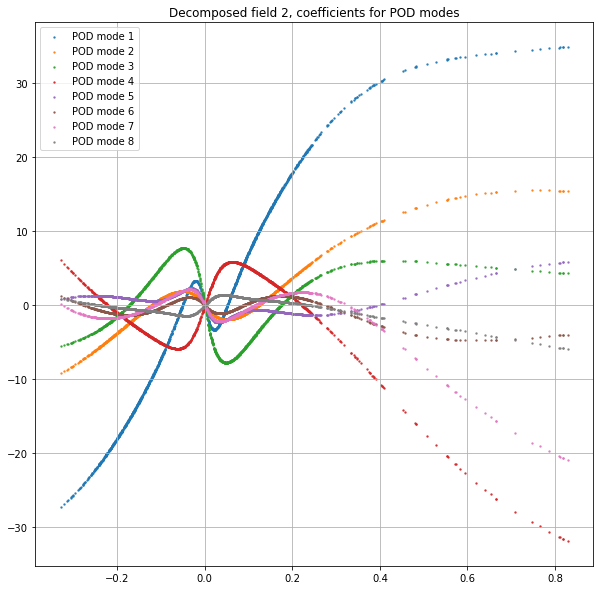

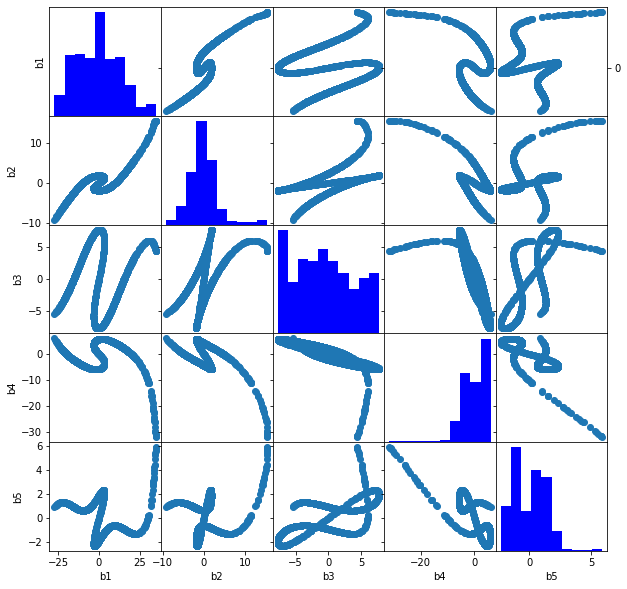

In [65]:
plt.figure(figsize=(10,10))
plt.title('Decomposed field 2, coefficients for POD modes')
for i in range(8):
    plt.scatter(latent_train[:,1], B[1,:,i], alpha=0.8,label=f'POD mode {i+1}',s=2)
plt.legend()
plt.grid()
plt.show()

fig, ax = myplot.scatter_matrix(B[1,:,:5],['b1','b2','b3','b4','b5'],kwargs_figure={'figsize':(10,10)},kwargs_hist={'color':'b'})

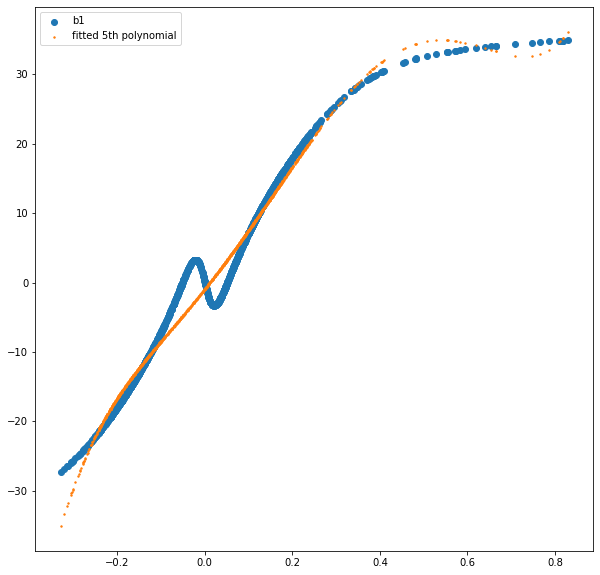

[  -0.91293288   79.07703244   52.44731386   79.06134677 -732.89692039
  603.88668262]


In [80]:
i = 0
degree = 5
w = 1/(B[1,:,i]+1)
idx = np.argsort(latent_train[:,1])
fn = np.polynomial.polynomial.Polynomial.fit(latent_train[:,1][idx],B[1,:,i][idx],degree)
fn_coeff = fn.convert().coef
fitted = np.polynomial.polynomial.polyval(latent_train[:,1],fn_coeff)
fig = plt.figure(figsize=(10,10))
plt.scatter(latent_train[:,1],B[1,:,i],label=f'b{i+1}')
plt.scatter(latent_train[:,1],fitted,label=f'fitted {degree}th polynomial',s=2)
plt.legend()
plt.show()
print(fn_coeff)

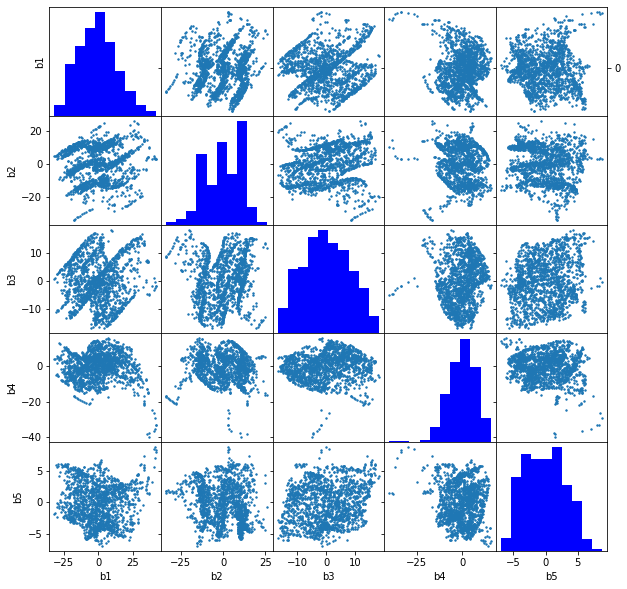

In [67]:
## total output
# B [latent_dim, time, POD modes]
B_total = np.sum(B,axis=0)
fig, ax = myplot.scatter_matrix(B_total[:,:5],['b1','b2','b3','b4','b5'],kwargs_figure={'figsize':(10,10)},kwargs_scatter={'s':2},kwargs_hist={'color':'b'})

## error

In [68]:
err = u_train - np.sum(modes_train,axis=0)
x_err = einsum('k t y z u -> k y z t u', err)
B_err = []
for i in range(err.shape[0]):
    X_err = np.vstack((x_err[i,:,:,:,0], x_err[i,:,:,:,1]))
    X_err = np.reshape(X_err,(-1, ntrain))
    b = einsum('x t, x m -> t m', X_err, Q_POD)
    B_err.append(b)
B_err = np.array(B_err) # [latent_dim, time, number of pod modes]

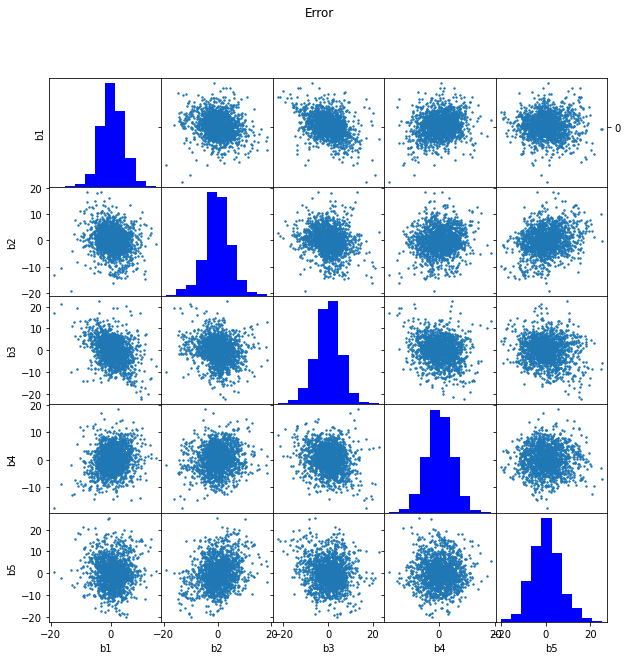

In [69]:
fig, ax = myplot.scatter_matrix(B_err[0,:,:5],['b1','b2','b3','b4','b5'],kwargs_figure={'figsize':(10,10)},kwargs_scatter={'s':2},kwargs_hist={'color':'b'})
fig.suptitle('Error')
plt.show()

In [70]:
B_total_with_err = np.sum(B,axis=0) + np.squeeze(B_err)
print("Is the sum of all b's A")
print(np.allclose(A,B_total_with_err,atol=10e-5))

Is the sum of all b's A
True


## Data

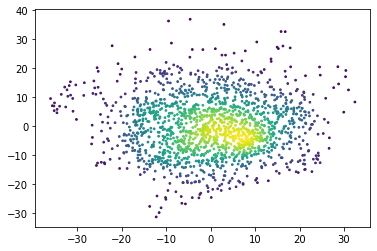

In [71]:
v1 = A[:,1]
v2 = A[:,2]
values = np.vstack([v1,v2])
kde = gaussian_kde(values)(values)
plt.figure()
plt.scatter(v1,v2,c=kde,s=3)
# plt.colorbar()
plt.show()

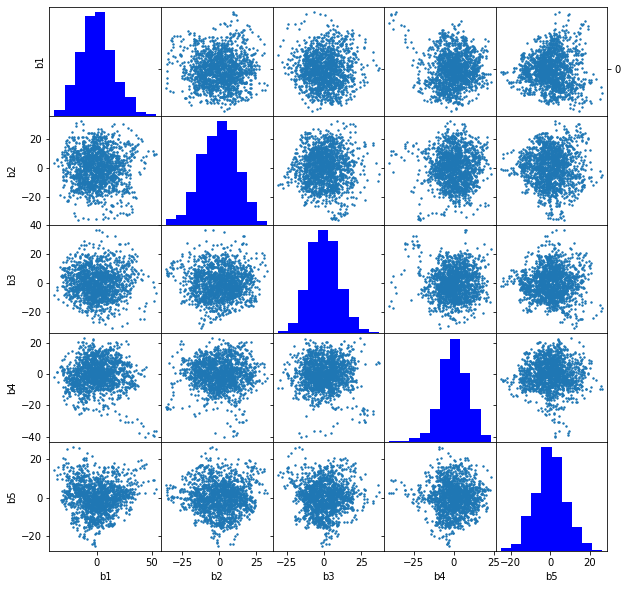

In [72]:
fig, ax = myplot.scatter_matrix(A[:,:5],['b1','b2','b3','b4','b5'],kwargs_figure={'figsize':(10,10)},kwargs_scatter={'s':2},kwargs_hist={'color':'b'})